# PML Tests for Electric Field

Electric field $\mathbf{E}$ has a well known phasor form $\mathbf{A}e^{\mathrm{i}\mathbf{k}\cdot\mathbf{x}}$ satisfying
\begin{align}
\nabla^2 \mathbf{E} + k^2 \mathbf{E} &= 0 &&\text{ in }\Omega \\
\mathbf{E}_{inc} &= - \mathbf{E}_{sca} &&\text{ on }\Gamma_{sca}
\end{align}
with $\mathbf{E} = \mathbf{E}_{inc} + \mathbf{E}_{sca} = \mathbf{0}$ and the Sommerfeld radiation condition 
\begin{equation}
\lim_{r\to\infty} r^{1/2} \left(\frac{\partial u}{\partial r} - i\omega u\right) = 0,
\end{equation}
where $r$ is the radial distance from the origin.


In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from netgen.webgui import Draw as Drawgeo
import matplotlib.pyplot as plt
import numpy as np

importing NGSolve-6.2.2301


Generating 2d rectangular mesh with a unit radius circular cavity. Also introducing an additional PML region o

In [2]:
def generate_mesh(h, inner_rect_size, PML_size):
    
    inner_rect=WorkPlane().RectangleC(inner_rect_size,inner_rect_size).Face()
    scatterer = WorkPlane().Circle(0,0,1).Face()

    inner_rect.edges.name = 'innerbnd'
    scatterer.edges.name = 'scabnd'

    inner = inner_rect - scatterer

    #Drawgeo(inner)

    wp2=WorkPlane().RectangleC(inner_rect_size+inner_rect_size,inner_rect_size+inner_rect_size).RectangleC(5,5).Reverse()
    outer = wp2.Face()

    outer.edges.name = 'outerbnd'
    #inner.edges.name = 'innerbnd'
    inner.faces.name ='inner'
    outer.faces.name = 'pmlregion'

    #Drawgeo(Glue([outer,inner]))

    geo = OCCGeometry(Glue([inner, outer]), dim=2)
    mesh = Mesh(geo.GenerateMesh (maxh=h))
    mesh.Curve(5)
    return mesh

inner_rect_size = 5
PML_size = 5
h = 0.3
mesh = generate_mesh(h, inner_rect_size, PML_size)
Draw(mesh)


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [3]:
K = CF((3.14159 * 2 , 0))
phasor = exp(1j * ((K[0] * x) + (K[1] * y)))
ez = 1 * phasor

In [4]:
def No_PML(mesh, p, K, ez):

    fes = H1(mesh, order=p, complex=True, dirichlet='scabnd')
    u = fes.TrialFunction()
    v = fes.TestFunction()

    omega = sqrt(K[0]**2 + K[1]**2)

    a = BilinearForm(fes, symmetric=True)
    a += grad(u)*grad(v)*dx - omega**2*u*v*dx
    a += -1j*omega*u*v*ds("outerbnd")
    a.Assemble()


    b = LinearForm(fes)
    b += SymbolicLFI(0)
    b.Assemble()

    scat = GridFunction(fes)
    scat.Set(-ez, BND)

    r = b.vec - a.mat * scat.vec
    scat.vec.data += a.mat.Inverse(freedofs=fes.FreeDofs()) * r
    return scat, fes.ndof

scat, _ = No_PML(mesh, 5, K, ez)

Draw(scat, mesh)
#Draw(ez, mesh)
#Draw(scat - ez, mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

## With PML

In [5]:
#K = CF((3.14159 * 2, 0))
#phasor = exp(1j * ((K[0] * x) + (K[1] * y)))
#ez = 1 * phasor

def absval(x):
    return sqrt(x**2)

d = inner_rect_size
omega = 2 * np.pi
z_x = IfPos(absval(x) - 2.5, x + (1j * ( absval(x) - d)/omega) * x, x) # returns z_j if |x|>2.5 else returns x
z_y = IfPos(absval(y) - 2.5, y + (1j * ( absval(y) - d)/omega) * y, y) # returns z_j if |y|>2.5 else returns y

Draw(z_x.imag, mesh)
Draw(z_y.imag, mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [6]:
dzx = z_x.Diff(x)
dzy = z_y.Diff(y)

Draw(dzx.imag, mesh)
Draw(dzy.imag, mesh)

dz_tot = dzx * dzy
Draw(dz_tot.imag,mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [7]:
Z = CF((dz_tot / (dzx**2), dz_tot / (dzy**2)))
#Z = CF((1,1))
#dz_tot = 1


def With_PML(mesh, p, K, ez, Z, dz_tot):

    fes = H1(mesh, order=p, complex=True, dirichlet='scabnd')
    u = fes.TrialFunction()
    v = fes.TestFunction()

    omega = sqrt(K[0]**2 + K[1]**2)

    inner = CF( Z[0] * grad(u)[0] * grad(v)[0] + Z[1] * grad(u)[1] * grad(v)[1])

    
    a = BilinearForm(fes, symmetric=True)
    a += inner * dx - dz_tot *omega**2*u*v * dx
    #a += -1j*omega*u*v * ds('outerbnd')

    #pre = Preconditioner(a, "bddc", coarsetype="h1amg")

    a.Assemble()


    b = LinearForm(fes)
    b += SymbolicLFI(0)
    b.Assemble()

    scat_pml = GridFunction(fes)
    scat_pml.Set(-ez, BND)

    r = b.vec.CreateVector()
    r = b.vec - a.mat * scat_pml.vec
    #inv = CGSolver(a.mat, pre.mat, maxsteps=2000)
    #scat_pml.vec.data += inv * r

    scat_pml.vec.data += a.mat.Inverse(freedofs=fes.FreeDofs()) * r
    return scat_pml, fes.ndof

scat_pml, _ = With_PML(mesh, 5, K, ez, Z, dz_tot)

Draw(scat_pml);
#Draw(ez, mesh)
#Draw(scat_pml - ez, mesh)



WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

## Exact solution:




Text(0.5, 1.0, 'Exact real')

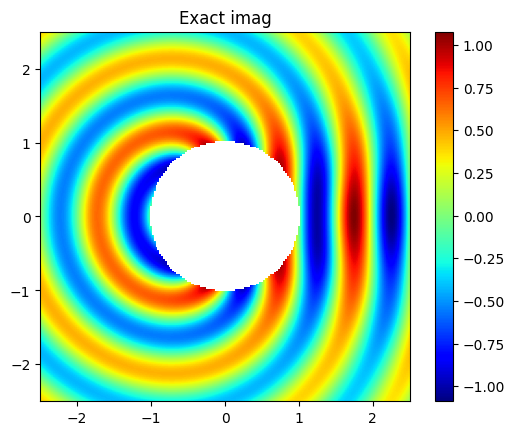

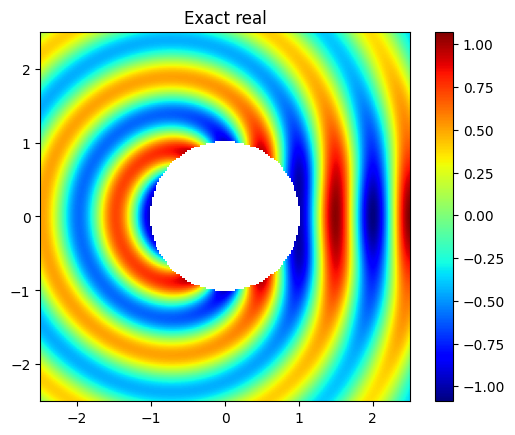

In [8]:
from scipy.special import jv as besselj
from scipy.special import yv as bessely
from scipy.special import hankel1, hankel2
import numpy as np
from matplotlib import pyplot as plt

omega = 2*np.pi

x_extent = np.linspace(-2.5, 2.5, 200)
y_extent = x_extent
xx,yy = np.meshgrid(x_extent, y_extent)

R = np.sqrt(xx**2 + yy**2)
theta = np.arctan2(yy, xx)


mask = np.ones(xx.shape)
for yind, yval in enumerate(yy):
    for xind, xval in enumerate(xx):
        if R[xind, yind] < 1:
            mask[xind, yind] = np.nan

zz = np.zeros(xx.shape)

TE = False
if TE is True:
# TE
    for n in range(30):
        dj=(-besselj(n-1,omega)+besselj(n+1,omega))/2
        dy=(-bessely(n-1,omega)+bessely(n+1,omega))/2
        dh=dj-1j*dy;

        z=omega*R;
        bj=besselj(n,z);
        by=bessely(n,z);
        h=bj-1j*by;
        if n==0:
            zz=zz-(dj/dh)*h*np.cos(n*theta)*(1j**(-n)) * mask
        else:
            zz=zz-2*(dj/dh)*h*np.cos(theta*n)*(1j**(-n)) * mask
            
else:
    for n in range(30):
        if n == 0:
            epsilon_n = 1
        else:
            epsilon_n = 2
        
        # for cylinder radius r=1
        
        jv_over_h2 = besselj(n, omega*1)/hankel1(n, omega*1)
        zz = zz -(1j)**n * epsilon_n * jv_over_h2 * hankel1(n, omega * R) * np.cos(theta*n) * mask
        
        #zz = np.conj(zz) # Don't know why this needs a conjugate. Probably something to do with the direction of the wave Balanis assumed.
        
plt.figure()
plt.imshow(zz.imag,extent=[-2.5,2.5, -2.5, 2.5] , cmap='jet')
plt.colorbar()
plt.title('Exact imag')

plt.figure()
plt.imshow(zz.real,extent=[-2.5,2.5, -2.5, 2.5], cmap='jet')
plt.colorbar()
plt.title('Exact real')


## Comparing FEM With Exact Solution



Text(0.5, 1.0, 'FEM. No PML Real')

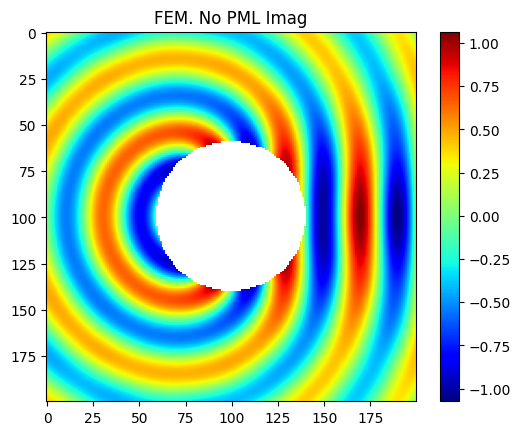

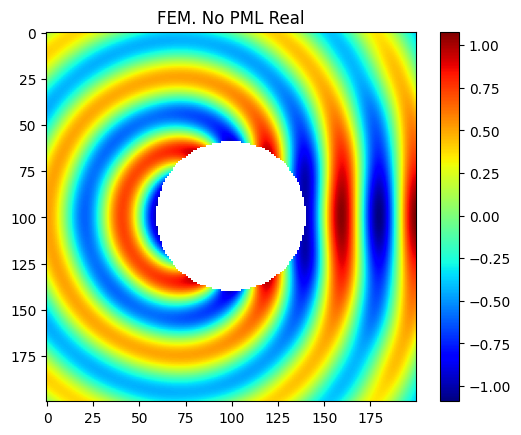

In [9]:
# NO PML
from ngsolve import *

def compute_on_meshgrid(xx, yy, scat, mask):
    scat_numpy = np.zeros(xx.ravel().shape, dtype=complex)
    for indx, xy in enumerate(zip(xx.ravel(), yy.ravel())):
        R = np.sqrt(xy[0]**2 + xy[1]**2)
        if R > 1:
            scat_numpy[indx] = scat(mesh(xy[0], xy[1]))

    scat_numpy = scat_numpy.reshape(xx.shape) * mask
    return scat_numpy

scat_numpy = compute_on_meshgrid(xx, yy, scat, mask)

plt.figure()
plt.imshow(scat_numpy.imag, cmap='jet')
plt.colorbar()
plt.title('FEM. No PML Imag')

plt.figure()
plt.imshow(scat_numpy.real, cmap='jet')
plt.colorbar()
plt.title('FEM. No PML Real')

Text(0.5, 1.0, 'FEM. With PML Real')

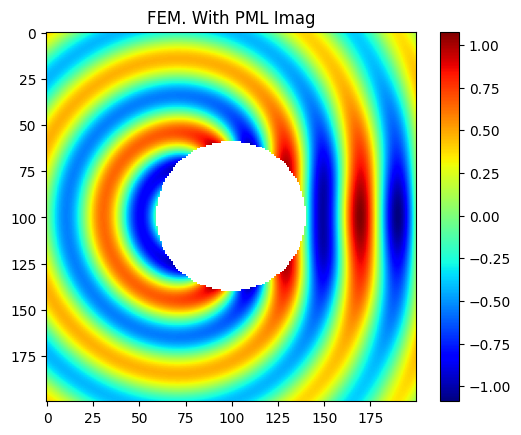

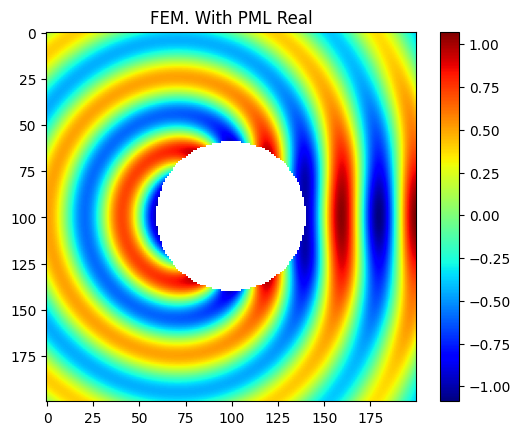

In [10]:
# With PML

scat_pml_numpy = compute_on_meshgrid(xx, yy, scat_pml, mask)
plt.figure()
plt.imshow(scat_pml_numpy.imag, cmap='jet')
plt.colorbar()
plt.title('FEM. With PML Imag')

plt.figure()
plt.imshow(scat_pml_numpy.real, cmap='jet')
plt.colorbar()
plt.title('FEM. With PML Real')

## p--refinement

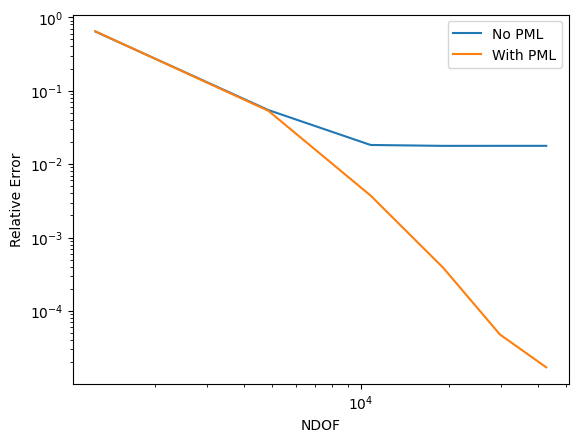

In [11]:
def compute_err(exact, approx):
    return np.linalg.norm((exact - approx)) / np.linalg.norm(exact)

error = []
ndof = []
for p in [0,1,2,3,4, 5,6]:
    scat, nd = No_PML(mesh, p, K, ez)
    scat_numpy = compute_on_meshgrid(xx, yy, scat, mask)
    
    scat_numpy_no_nans = scat_numpy[~np.isnan(scat_numpy)]    
    exact_no_nans = zz[~np.isnan(zz)]
    
    err = compute_err((np.asarray(exact_no_nans)), np.asarray(scat_numpy_no_nans))
    ndof += [nd]
    error += [err]

    
plt.figure(1)
plt.loglog(ndof, error, label='No PML')

error = []
ndof = []
for p in [0,1,2,3,4,5,6]:
    scat_pml, nd_pml =  With_PML(mesh, p, K, ez, Z, dz_tot)
    scat_pml_numpy = compute_on_meshgrid(xx, yy, scat_pml, mask)
    
    scat_pml_numpy_no_nans = scat_pml_numpy[~np.isnan(scat_pml_numpy)]
    exact_no_nans = zz[~np.isnan(zz)]
    
    err = compute_err((np.asarray(exact_no_nans)), np.asarray(scat_pml_numpy_no_nans))
    ndof += [nd_pml]
    error += [err]

plt.figure(1)
plt.loglog(ndof, error, label='With PML')
plt.ylabel('Relative Error')
plt.xlabel('NDOF')
plt.legend()

## hp--refinement PML:



solving for h=0.5
solving for h=0.4
solving for h=0.3
solving for h=0.2
solving for h=0.1


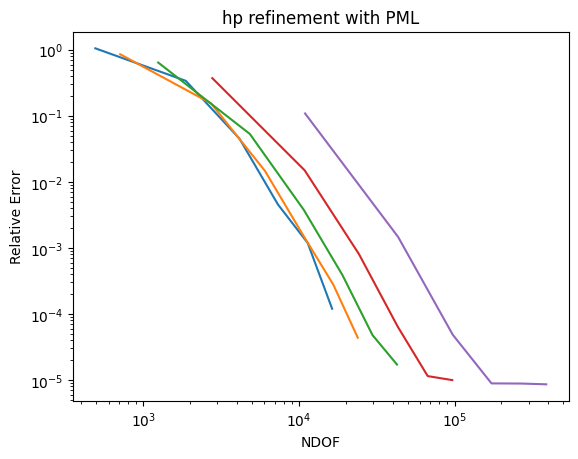

In [12]:

for h in [0.5, 0.4, 0.3, 0.2, 0.1]:
    print(f'solving for h={h}')
    error = []
    ndof = []
    mesh = generate_mesh(h, inner_rect_size, PML_size)
    for p in [0,1,2,3,4,5,6]:
        scat_pml, nd_pml =  With_PML(mesh, p, K, ez, Z, dz_tot)
        scat_pml_numpy = compute_on_meshgrid(xx, yy, scat_pml, mask)

        scat_pml_numpy_no_nans = scat_pml_numpy[~np.isnan(scat_pml_numpy)]
        exact_no_nans = zz[~np.isnan(zz)]

        err = compute_err((np.asarray(exact_no_nans)), np.asarray(scat_pml_numpy_no_nans))
        ndof += [nd_pml]
        error += [err]

    plt.figure(1)
    plt.loglog(ndof, error)
    plt.ylabel('Relative Error')
    plt.xlabel('NDOF')
    plt.title('hp refinement with PML')

solving for h=0.5
solving for h=0.4
solving for h=0.3
solving for h=0.2
solving for h=0.1


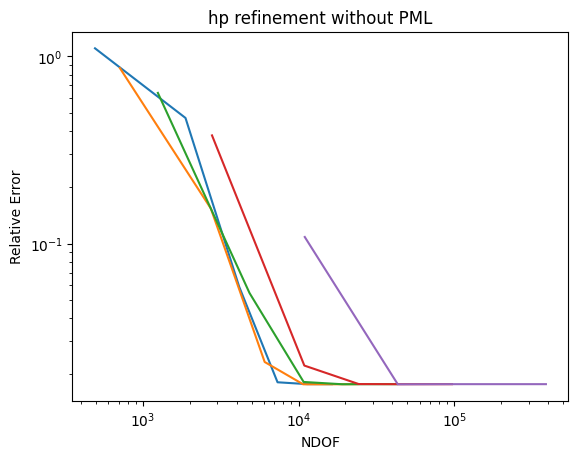

In [13]:
# hp refinement without PML
for h in [0.5, 0.4, 0.3, 0.2, 0.1]:
    print(f'solving for h={h}')
    error = []
    ndof = []
    mesh = generate_mesh(h, inner_rect_size, PML_size)
    for p in [0,1,2,3,4,5,6]:
        scat, nd =  No_PML(mesh, p, K, ez)
        scat_numpy = compute_on_meshgrid(xx, yy, scat, mask)

        scat_numpy_no_nans = scat_numpy[~np.isnan(scat_numpy)]
        exact_no_nans = zz[~np.isnan(zz)]

        err = compute_err((np.asarray(exact_no_nans)), np.asarray(scat_numpy_no_nans))
        ndof += [nd]
        error += [err]

    plt.figure(1)
    plt.loglog(ndof, error)
    plt.ylabel('Relative Error')
    plt.xlabel('NDOF')
    plt.title('hp refinement without PML')

## Comparison with RCS


In [14]:
"""
from ngsolve import *

d = 2
theta = np.linspace(-np.pi, np.pi, 100)
x = d * np.cos(theta)
y = d * np.sin(theta)
z_sca = np.zeros(theta.shape, dtype=complex)
for ind, xy in enumerate(zip(x,y)):
    z_sca[ind] = scat_pml(mesh(xy[0], xy[1]))

z = np.zeros(theta.shape, dtype=complex)
for n in range(30):
    if n == 0:
        epsilon_n = 1
    else:
        epsilon_n = 2

    # for cylinder radius r=1

    jv_over_h2 = besselj(n, omega*1)/hankel2(n, omega*1)
    z = z -(-1j)**n * epsilon_n * jv_over_h2 * hankel2(n, omega * d) * np.cos(theta*n)

RCS = 2*np.pi * d * (z * np.conj(z))
RCS_PML = 2*np.pi * d * (z_sca * np.conj(z_sca))
plt.figure()
plt.plot(theta*180/np.pi, 10*np.log10(np.abs(RCS)), label='Exact')
plt.plot(theta*180/np.pi, 10*np.log10(np.abs(RCS_PML)), label='FEM')

plt.legend()
plt.ylabel('RCS, dB')
plt.xlabel('Ang')
"""

# Numerical RCS:
for ang in [0]:
    normal = CF((np.cos(ang), np.sin(ang), 0))
    r = 1
    coord = np.asarray([r*np.cos(ang), r*np.sin(ang),0])
    E_exact = np.asarray([np.zeros(xx.shape), np.zeros(yy.shape), zz])
    phasor = np.exp(-1j*omega * np.sum(coord, axis=0))
    
    V = CF((0, 0, 1 * phasor))
    Y = CF((-np.sin(ang), np.cos(ang), 0))
    
    
    fes = H1(mesh, order=5, complex=True, dirichlet='scabnd')
    gfu = GridFunction(fes)
    gfu.Set(V[2])

In [15]:
mesh = generate_mesh(h, inner_rect_size, PML_size)
fes = H1(mesh, order=5, complex=True)
gfu = GridFunction(fes)
mesh.dim

2

In [16]:
fes.dim

1